In [65]:
# %%file strategy_4.py

import import_ipynb
from strategy_base import TradeStrategyBase

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class TradeStrategy4:
    """
    Trade Strategy 4: Slope and Velocity.
    Overview:
    Use close price to draw a trend, use the derivative to find the slope.
    Use the derivative again to find the velocity for change.
    
    When price raises rapidly, slope > 0, velocity > 0
    When price raises becomes slowly, slope > 0, velocity close 0
    When price peaks, slope = 0, 
    When price falls rapidly, slope < 0, velocity > 0
    When price falls slowly, slope < 0, velocity close to 0 
    When price bottoms, slope = 0,
    
    Therefore, we can use a slope and velocity to find trends and make trades.
    
    Long when price is rising (slope > _buy_slope_threshold > 0) & accelerating (velocity > _buy_velocity_threshold > 0) & Close when price starting to fall (slope < -_close_slope_threshold < 0 and velocity < -_close_velocity_threshold < 0)
    Short when price is falling (slope < _sell_slope_threshold < 0) & accelerating (velocity < _sell_velocity_threshold < 0) & Close when price starting to fall (slope > _close_slope_threshold > 0 and velocity > _close_velocity_threshold > 0)
    
    Assumptions: 
    
    Requirement: 
    1. This strategy should work with any highly liquid security. Preferably Forex or Crypto.
    2. This strategy should work whether trend is up or down, volatile or not. 
    3. The more volatile, the better, as we need to quickly close the position after mean reversion, BEFORE moving_average moved too much. 
    Constants: 
    Params:
    _buy_slope_threshold:       # The slope required to trigger BUY
    _buy_velocity_threshold:    # The velocity required to trigger BUY
    _close_slope_threshold:     # The slope required to trigger CLOSE
    _close_velocity_threshold:  # The slope required to trigger CLOSE
    _sell_slope_threshold:      # The slope required to trigger SELL
    _sell_velocity_threshold:   # The velocity required to trigger SELL
    """
    _buy_slope_threshold = 0.1
    _buy_velocity_threshold = 0.1
    _close_slope_threshold = 0.1
    _close_velocity_threshold = 0.1
    _sell_slope_threshold = -0.1
    _sell_velocity_threshold = -0.1
    
    def __init__(self, leverage:int=1, margin:float=0, buy_slope_threshold:float = 0.1, buy_velocity_threshold:float = 0.1, close_slope_threshold:float = 0.1, close_velocity_threshold:float = 0.1, sell_slope_threshold:float = -0.1, sell_velocity_threshold:float = -0.1, should_log:bool = False, should_plot:bool = False, axs = None):
        """
        Initialize Strategy with given parameters
        :type leverage: float
        :type margin: float
        :type buy_slope_threshold: float
        :type buy_velocity_threshold: float 
        :type close_slope_threshold: float
        :type close_velocity_threshold: float 
        :type sell_slope_threshold: float
        :type sell_velocity_threshold: float  
        :type should_log: bool
        :type should_plot: bool
        :param leverage: The leverage
        :param margin: The margin interest rate
        :param buy_slope_threshold: # The slope required to trigger BUY
        :param buy_velocity_threshold: # The velocity required to trigger BUY 
        :param close_slope_threshold: # The slope required to trigger CLOSE
        :param close_velocity_threshold: # The slope required to trigger CLOSE 
        :param sell_slope_threshold: # The slope required to trigger SELL
        :param sell_velocity_threshold: # The velocity required to trigger SELL 
        :param should_log Whether or not log the strategy
        :param should_plot Whether or not plot the strategy
        """
        self._leverage = leverage
        self._margin_interest = margin
        self._buy_slope_threshold = buy_slope_threshold
        self._buy_velocity_threshold = buy_velocity_threshold
        self._close_slope_threshold = close_slope_threshold
        self._close_velocity_threshold = close_velocity_threshold
        self._sell_slope_threshold = sell_slope_threshold
        self._sell_velocity_threshold = sell_velocity_threshold
        self._should_log = should_log
        self._should_plot = should_plot
        self._axs = axs
        
    def trade(self, data_df:pd.DataFrame):
        """
        Perform Analysis, Decide on Trade, and Execute Trade
        :type data_df: pd.DataFrame
        :param data_df: The DataFrame for data
        :return: 
        """
            
        """
        Firstly, add `slope` and `velocity` columns to DataFrame
        """
        extra_df = data_df.copy()
        extra_df['slope'] = pd.Series(np.gradient(extra_df.close), extra_df.index, name='slope')
        extra_df['velocity'] = pd.Series(np.gradient(extra_df.slope), extra_df.index, name='velocity')
        
        """
        Secondly, Closing
        """
        extra_df['position'] = "CLOSE"
        
        """
        Thirdly, Buying
        """
        long_mask = (extra_df.slope > self.buy_slope_threshold) & (extra_df.velocity > self.buy_velocity_threshold)
        long_close = (extra_df.slope < -self.close_slope_threshold) & (extra_df.velocity < -self.close_velocity_threshold)
        extra_df.loc[long_mask, 'position'] = "LONG"
        
        """
        Finally, Selling
        """
        short_mask = (extra_df.slope < self.sell_slope_threshold) & (extra_df.velocity < self.sell_velocity_threshold)
        short_close = (extra_df.slope > self.close_slope_threshold) & (extra_df.velocity > self.close_velocity_threshold)
        extra_df.loc[short_mask, 'position'] = "SHORT"
        
        self._data_df = extra_df
        return extra_df

    def _plot_trade(self, axs, buy_date, sell_date):

        print("Todo: Plotting {} {}".format(buy_date, sell_date))

        # buy_tradeday = self._held_tradedays[buy_date.date()]
        # sell_tradeday = self._held_tradedays[sell_date.date()]
        # print("Bought at {}, Sold at {}".format(buy_tradeday.close, sell_tradeday.close))

        # drawer = plt if axs is None else axs
        # 
        # # Mark red for up and green for down, slicing using start and end
        # if sell_tradeday.close < buy_tradeday.close:
        #   drawer.fill_between(self._held_tradedays.index[buy_date:sell_date], 0,
        #                   self._held_tradedays['close'][buy_date:sell_date], color='red',
        #                   alpha=.38)
        #   is_win = False
        # else:
        #   drawer.fill_between(amex_df.index[buy_date:sell_date], 0,
        #                   amex_df['close'][buy_date:sell_date], color='green',
        #                   alpha=.38)
        #   is_win = True
        # 
        # return is_win
        
    @property
    def trade_profit(self):
        long_series = self._data_df.p_change.where(self._data_df.position == "LONG").dropna()
        long_array = long_series.values * self._leverage # Assuming Forex Margin Trading,
        margin_cost = self._margin_interest / 365 * len(long_series) 
        long_profit = np.product(long_array/100 + 1) - 1 - margin_cost
        
        short_series = self._data_df.p_change.where(self._data_df.position == "SHORT").dropna()
        short_array = short_series.values * self._leverage # Assuming Forex Margin Trading,
        margin_cost = self._margin_interest / 365 * len(short_array)
        short_profit = np.abs(np.product(short_array/100 - 1)) - 1 - margin_cost
        
        trade_profit = long_profit + short_profit
        return trade_profit
    
    @property
    def buy_slope_threshold(self):
        return self._buy_slope_threshold
    
    @property
    def buy_velocity_threshold(self):
        return self._buy_velocity_threshold
    
    @property
    def close_slope_threshold(self):
        return self._close_slope_threshold
    
    @property
    def close_velocity_threshold(self):
        return self._close_velocity_threshold
    
    @property
    def sell_slope_threshold(self):
        return self._sell_slope_threshold
    
    @property
    def sell_velocity_threshold(self):
        return self._sell_velocity_threshold
    
    @property
    def data_df(self):
        return self._data_df
    

In [94]:
 
forex_df = pd.read_csv('../../data/gen/AUDUSD_Daily_df.csv',
                       parse_dates=True,
                       index_col=0)
# Strip whitespace from column names
forex_df.columns = forex_df.columns.str.strip()

leverage = 400 # 400 Leverage
margin = 0.1 # 10% Margin Interest
one_trade_week = 5
one_trade_month = one_trade_week * 4
two_trade_month = one_trade_month * 2
three_trade_month = one_trade_month * 3
half_trade_year = one_trade_month * 6
one_trade_year = half_trade_year * 2
buy_slope_threshold = 0.00011578947368419412 
buy_velocity_threshold = -0.01695000000000002
close_slope_threshold = 0.017273684210526295
close_velocity_threshold = 0.018381578947368395
sell_slope_threshold = -0.00011578947368419412
sell_velocity_threshold = 0.01695000000000002 

strategy = TradeStrategy4(leverage=leverage,
                          margin=margin,
                          buy_slope_threshold=buy_slope_threshold, 
                          buy_velocity_threshold=buy_velocity_threshold, 
                          close_slope_threshold=close_slope_threshold, 
                          close_velocity_threshold=close_velocity_threshold, 
                          sell_slope_threshold=sell_slope_threshold, 
                          sell_velocity_threshold=sell_velocity_threshold, 
                          should_log = False)
forex_df = strategy.trade(data_df=forex_df)
test_df = forex_df[-one_trade_year*2:]
test_df = strategy.trade(data_df=test_df)

print("In latest {} trading days, Strategy 4 resulted {}%".format(len(test_df.index), round(strategy.trade_profit * 100, 2)))

# Print
forex_df.head()


In latest 480 trading days, Strategy 4 resulted 1908.93%


,timestamp,open,high,low,close,pre_close,p_change,pip_change,slope,velocity,position
,,,,,,,,,,,
4999,2001-05-10,0.5233,0.5267,0.5217,0.5237,0.5233,0.000764,7.643799,-0.00210,-0.000100,SHORT
4998,2001-05-11,0.5237,0.5252,0.5184,0.5216,0.5237,-0.004010,-40.099293,-0.00220,0.000800,SHORT
4997,2001-05-14,0.5213,0.5224,0.5154,0.5193,0.5216,-0.004410,-44.095092,-0.00050,0.002100,SHORT
4996,2001-05-15,0.5193,0.5212,0.5150,0.5206,0.5193,0.002503,25.033699,0.00200,0.002075,LONG
4995,2001-05-16,0.5209,0.5240,0.5182,0.5233,0.5206,0.005186,51.863235,0.00365,0.000450,LONG



## Plotting

### Pip Change

Probability Distribution Function for daily pip_change.

Daily pip Change for AUDUSD since 2001-05-11


count    4999.000000
mean        0.000085
std         0.007776
min        -0.082655
25%        -0.003668
50%         0.000255
75%         0.004112
max         0.083761
Name: p_change, dtype: float64

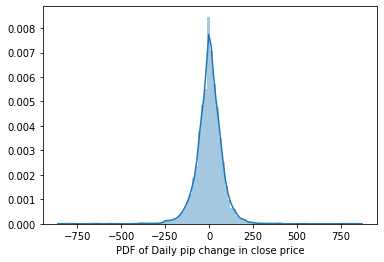

In [95]:
import seaborn as sns

sns.distplot(forex_df.pip_change,
             axlabel="PDF of Daily pip change in close price",
             bins=100)
print("Daily pip Change for AUDUSD since 2001-05-11")
forex_df.p_change.describe()


### `Slope` Analysis


Slope for AUDUSD since 2001-05-11


count    4999.000000
mean        0.000032
std         0.004218
min        -0.034200
25%        -0.002000
50%         0.000200
75%         0.002350
max         0.031000
Name: slope, dtype: float64

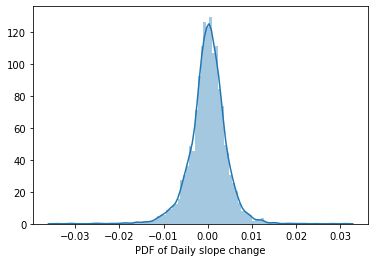

In [96]:

sns.distplot(forex_df.slope,
             axlabel="PDF of Daily slope change",
             bins=100)
print("Slope for AUDUSD since 2001-05-11")
forex_df.slope.describe()



### `Velocity` Analysis


Velocity for AUDUSD since 2001-05-11


count    4.999000e+03
mean    -5.801160e-07
std      3.020596e-03
min     -1.695000e-02
25%     -1.625000e-03
50%      2.775558e-17
75%      1.600000e-03
max      3.260000e-02
Name: velocity, dtype: float64

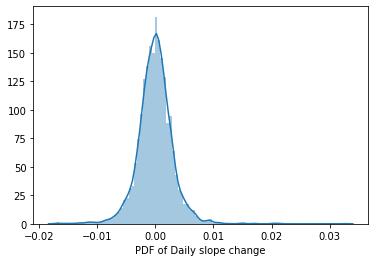

In [97]:

sns.distplot(forex_df.velocity,
             axlabel="PDF of Daily slope change",
             bins=100)
print("Velocity for AUDUSD since 2001-05-11")
forex_df.velocity.describe()



### Close Price

#### Line Chart


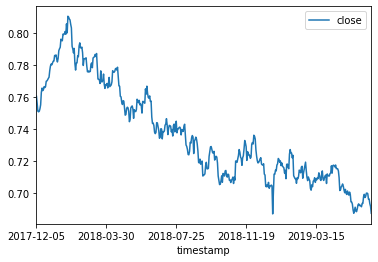

In [98]:

test_df.plot(x="timestamp", 
             y="close")



#### Candlesticks Chart


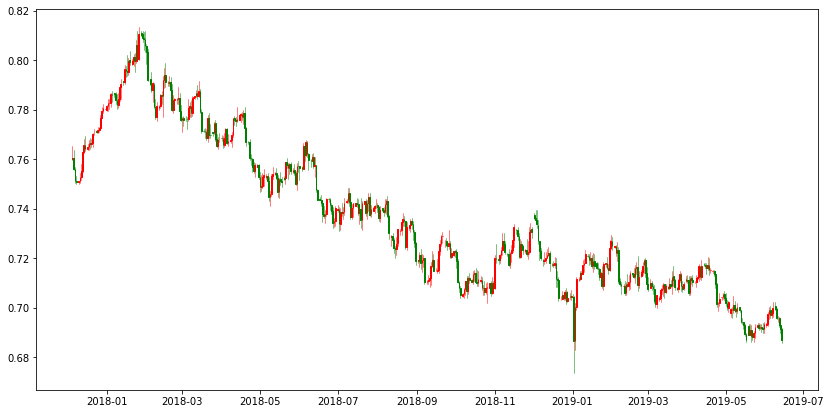

In [99]:
from matplotlib.dates import datestr2num
import mpl_finance as mpf
__colorup__ = "red"
__colordown__ = "green"

fix, axs = plt.subplots(figsize=(14, 7))
quotes = []
for index, (d, o, c, h, l) in enumerate(
    zip(
        test_df.timestamp, 
        test_df.open,
        test_df.close,
        test_df.high,
        test_df.low
    )):
    # Draw Candle Sticks
    d = datestr2num(d)
    # Date, Open, CLose, High, Low tuple 
    val = (d, o, c, h, l)
    # Add val to quotes
    quotes.append(val)
    
mpf.candlestick_ochl(axs, 
                     quotes,
                     width=0.6,
                     colorup=__colorup__,
                     colordown=__colordown__)
axs.autoscale_view()
axs.xaxis_date()


#### Plot Trade


SHORT 2017-12-05 - 2017-12-06, Profit: $565.42 (56.54 pips)
SHORT 2017-12-06 - 2017-12-07, Profit: $661.2 (66.12 pips)
CLOSE 2017-12-10
LONG 2017-12-10 - 2017-12-11, Profit: $213.02 (21.3 pips)
LONG 2017-12-11 - 2017-12-12, Profit: $332.14 (33.21 pips)
LONG 2017-12-12 - 2017-12-13, Profit: $1032.84 (103.28 pips)
LONG 2017-12-13 - 2017-12-14, Profit: $353.87 (35.39 pips)
SHORT 2017-12-14 - 2017-12-15, Profit: $208.96 (20.9 pips)
LONG 2017-12-15 - 2017-12-17, Profit: $91.61 (9.16 pips)
LONG 2017-12-17 - 2017-12-18, Profit: $235.36 (23.54 pips)
CLOSE 2017-12-20
LONG 2017-12-20 - 2017-12-21, Profit: $443.52 (44.35 pips)
LONG 2017-12-21 - 2017-12-22, Profit: $25.97 (2.6 pips)
LONG 2017-12-22 - 2017-12-24, Profit: $90.89 (9.09 pips)
LONG 2017-12-24 - 2017-12-25, Profit: $116.75 (11.67 pips)
LONG 2017-12-25 - 2017-12-26, Profit: $90.7 (9.07 pips)
LONG 2017-12-26 - 2017-12-27, Profit: $530.74 (53.07 pips)
LONG 2017-12-27 - 2017-12-28, Profit: $373.42 (37.34 pips)
LONG 2017-12-28 - 2017-12-29, 

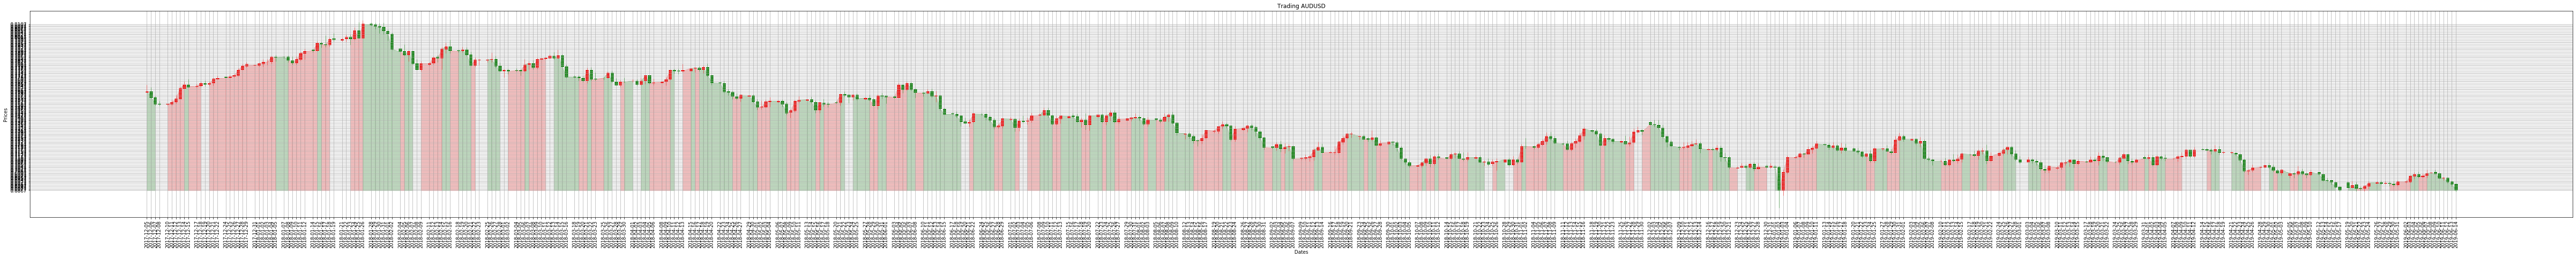

In [100]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize = (int(len(test_df.index)/5),8))
    
mpf.candlestick_ochl(axs, 
                     quotes,
                     width=0.6,
                     colorup=__colorup__,
                     colordown=__colordown__)
axs.autoscale_view()
axs.xaxis_date()

# axs.fill_between(test_df.timestamp,
#                     min(test_df.close),
#                     test_df.close,
#                     color='yellow',
#                     alpha=.05)

current_index = -1
current_position = ""
for i, tradeday_row in test_df.iterrows():
    # if current_position == tradeday_row.position: 
    #     # Do nothing
    #     print("Skipping SAME {}".format(tradeday_row.timestamp))
    # else:
        if current_position == "":
            # First Day Ever, set initial value
            current_index = i
            current_position = tradeday_row.position
        else:
            # Plot The Trade
            if current_position == "CLOSE":
                # If last position was "CLOSED", do nothing
                print("CLOSE {}".format(tradeday_row.timestamp))
            else:
                if tradeday_row.position == "LONG":
                    print("LONG {} - {}, Profit: ${} ({} pips)".format(test_df.timestamp[current_index], tradeday_row.timestamp, round(tradeday_row.pip_change*10, 2), round(tradeday_row.pip_change, 2)))
                    axs.fill_between(test_df.loc[current_index:i, 'timestamp'],
                                        min(test_df.close),
                                        test_df.loc[current_index:i, 'close'],
                                        color='red',
                                        alpha=.25)
                elif tradeday_row.position == "SHORT":
                    print("SHORT {} - {}, Profit: ${} ({} pips)".format(test_df.timestamp[current_index], tradeday_row.timestamp, -round(tradeday_row.pip_change*10, 2), -round(tradeday_row.pip_change, 2)))
                    axs.fill_between(test_df.loc[current_index:i, 'timestamp'],
                                        min(test_df.close),
                                        test_df.loc[current_index:i, 'close'],
                                        color='green',
                                        alpha=.25)
                
            # Reset Current Date & Position
            current_index = i
            current_position = tradeday_row.position
        
# Plot Labels
axs.set_xlabel('Dates')
axs.set_ylabel('Prices')
axs.set_title('Trading AUDUSD')
axs.set_xticks(test_df.timestamp.values)
axs.set_yticks(np.arange(min(test_df.close), max(test_df.close), 0.0010))
axs.set_xticklabels(test_df.timestamp.values, rotation=90)
axs.grid(True)
fig.savefig('../gen/AUDUSD_Strategy4.svg', dpi=500, bbox_inches="tight")